# IT3212

### Importing libraries

In [98]:
# Standard libraries
import numpy as np
import pandas as pd
import re
import string

# NLTK tools and datasets
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Uncomment if you need to download NLTK data packages
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Text processing
import contractions

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix)
from sklearn.model_selection import cross_val_predict

# Miscellaneous
from collections import Counter
from urllib.parse import unquote
from scipy import stats
import chardet


### Fix dataset encoding issues

Some rows in the raw data include non UTF-8 characters. 

Example of text with non UTF-8 characters:
778245336,FALSE,finalized,5,8/30/15 13:27,Not Relevant,0.7952,,army,
text column: Pakistan,".: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo Indian Army ki��_ http://t.co/WJLJq3yA4g"
,6.29079E+17,195397186

Chardet identifies the encoding of the raw data as 'MacRoman'.
For now, we will remove all non UTF-8 characters from the raw data
We handle this by removing all � characters from the raw data and writing the modified content back to the file.


In [99]:
def fix_non_utf8_encoding(filepath, destination_filepath):
    with open(filepath, 'rb') as file:
        rawdata = file.read()
        result = chardet.detect(rawdata)
        print(result['encoding'])


    # Open the file in read mode, read its contents, then close it
    with open('data/disaster-tweets.csv', 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Remove all � characters
    content = content.replace('�', '')

    # Open the file in write mode and write the modified content back to it
    with open(destination_filepath, 'w', encoding='utf-8') as file:
        file.write(content)

filepath = 'data/disaster-tweets.csv'
dest = 'data/disaster-tweets-utf8.csv'

# fix_non_utf8_encoding(filepath, dest) # Uncomment to fix raw dataset

In [100]:
def split_train_test(filepath, destination_filepath_train, destination_filepath_test):
    df = pd.read_csv(filepath, encoding='utf-8')
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    train_data.to_csv(destination_filepath_train, index=False)
    test_data.to_csv(destination_filepath_test, index=False)

filepath = 'data/disaster-tweets-utf8.csv'
dest_train = 'data/train.csv'
dest_test = 'data/test.csv'

# split_train_test(filepath, dest_train, dest_test)

### Importing dataset

In [101]:
import_remote = False

if import_remote:
    df_train = pd.read_csv('https://raw.githubusercontent.com/magnusrodseth/it3212/main/data/train.csv', encoding='utf-8')
    df_test = pd.read_csv('https://raw.githubusercontent.com/magnusrodseth/it3212/main/data/test.csv', encoding='utf-8')
else:
    df_train = pd.read_csv('./data/train.csv', encoding='utf-8')
    df_test = pd.read_csv('./data/test.csv', encoding='utf-8')

# print shapes of train and test
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
df_train.head()

Train shape: (8700, 13)
Test shape: (2176, 13)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778253309,False,finalized,5,8/27/15 16:07,Not Relevant,1.0000,NaN,screamed,NaN,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,6.291070e+17,2.327739e+08
1,778251995,False,finalized,5,8/27/15 20:16,Not Relevant,1.0000,NaN,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,6.290180e+17,2.750220e+07
2,778247239,False,finalized,5,8/30/15 0:15,Not Relevant,1.0000,NaN,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,6.290920e+17,6.052387e+08
3,778255430,False,finalized,5,8/27/15 17:03,Relevant,0.7978,NaN,wounded,NaN,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,6.291190e+17,2.305930e+09
4,778255609,False,finalized,5,8/27/15 22:11,Not Relevant,1.0000,NaN,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,6.290800e+17,2.464266e+07


##  Exploratory data analysis (EDA)

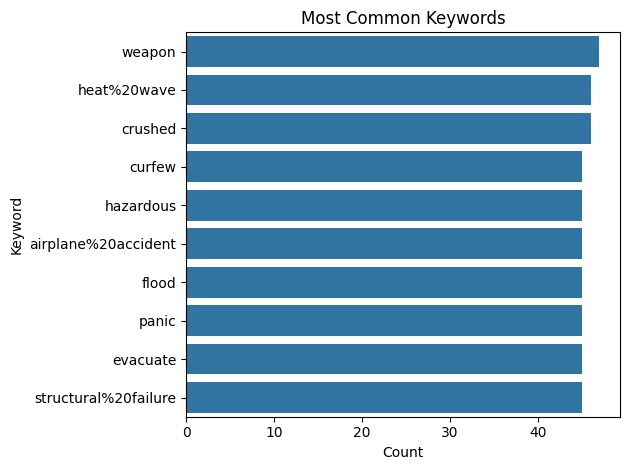

In [102]:
# Plot the most common keywords
defined_keywords = df_train[df_train['keyword'] != '']['keyword']

plt.figure()
sns.countplot(y=defined_keywords, order=defined_keywords.value_counts().iloc[:10].index)
plt.title('Most Common Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.tight_layout()
plt.show()

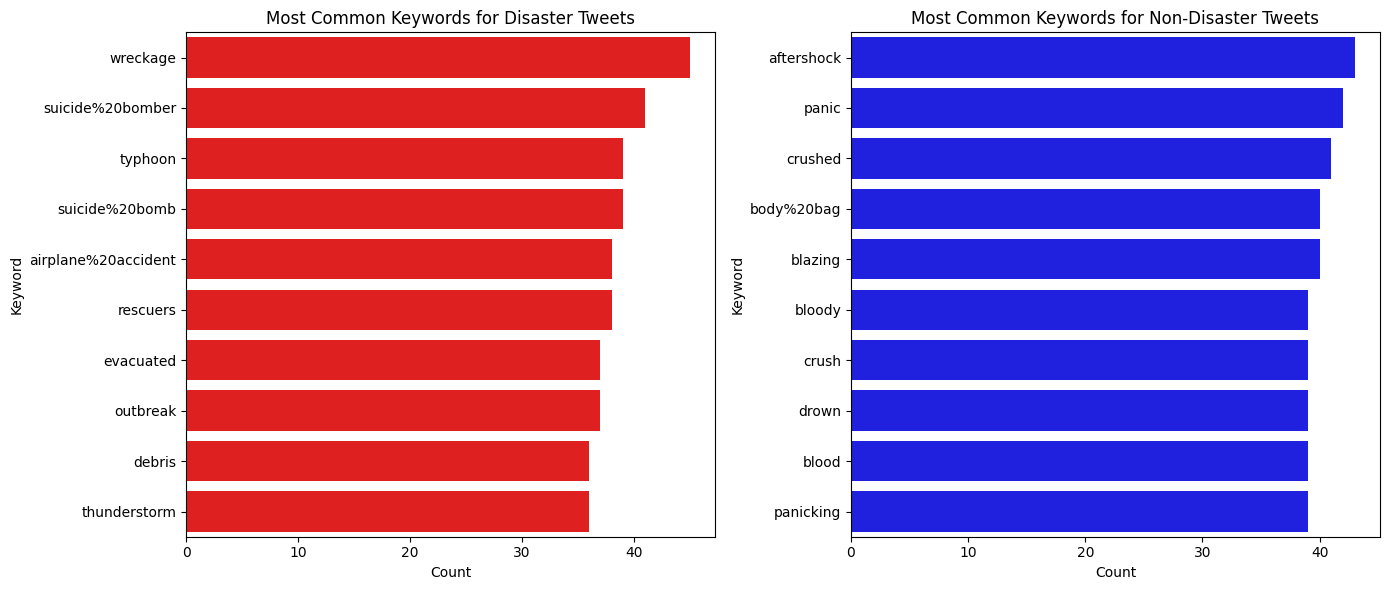

In [103]:
# Compare keywords for disaster tweets and non-disaster tweets
disaster_keywords = df_train[df_train['choose_one'] == 'Relevant']['keyword']
non_disaster_keywords = df_train[df_train['choose_one'] == 'Not Relevant']['keyword']

# Create a figure object and define the grid
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting
sns.countplot(y=disaster_keywords, ax=ax[0], order=disaster_keywords.value_counts().iloc[:10].index, color='red')
sns.countplot(y=non_disaster_keywords, ax=ax[1], order=non_disaster_keywords.value_counts().iloc[:10].index, color='blue')

# Titles and labels
ax[0].set_title('Most Common Keywords for Disaster Tweets')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Keyword')

ax[1].set_title('Most Common Keywords for Non-Disaster Tweets')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Keyword')

# Adjust layout
plt.tight_layout()
plt.show()



In the plot above, we can see that the top 10 shared keywords of disaster-related tweets and non-disaster-related tweets do not share any common keywords.

## 1. Preprocessing

In [104]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
english_stopwords = stopwords.words("english")

def filter_rows_by_confidence_and_decision(df, confidence_threshold):
    df = df[df['choose_one:confidence'] >= confidence_threshold]
    df = df[df['choose_one'] != "Can't Decide"]
    return df

def map_choose_one_to_target(df):
    df['target'] = df['choose_one'].apply(lambda choice: 1 if choice == 'Relevant' else 0)
    return df

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub('\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in english_stopwords])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    text = contractions.fix(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

def clean_keyword(keyword):
    return unquote(keyword) if pd.notnull(keyword) else ''

def clean_data(df):
    df['keyword'] = df['keyword'].apply(clean_keyword).apply(str.lower)
    df['text_raw'] = df['text']
    df['text'] = df['text'].apply(clean_text)
    return df

initial_count = df_train.shape[0]
confidence_threshold = 0.7

df_train = filter_rows_by_confidence_and_decision(df_train, confidence_threshold)
print("Removed {} of total: {} rows. Remaining rows: {}".format(initial_count - df_train.shape[0], initial_count, df_train.shape[0]))

features_to_keep = ['target', 'text', 'keyword']

df_train = map_choose_one_to_target(df_train)
df_train = df_train[features_to_keep]
df_train = clean_data(df_train)

count_initial = df_train.shape[0]
df_train = df_train.drop_duplicates(subset=['text'])
print("Removed {} duplicated rows.".format(count_initial - df_train.shape[0]))


# Preprocess the test data as well
df_test = map_choose_one_to_target(df_test)
df_test = df_test[features_to_keep]
df_test = clean_data(df_test)

df_test.head()


Removed 2167 of total: 8700 rows. Remaining rows: 6533
Removed 638 duplicated rows.


,target,text,keyword,text_raw
0,1,sunset looked like erupting volcano initial thought pixar short lava,volcano,The sunset looked like an erupting volcano .... My initial thought was the Pixar short Lava http://t.co/g4sChqFEsT
1,1,7294 nikon d50 61 mp digital slr camera body 2 battery carry bag charger 20000,body bag,#7294 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/SL7PHqSGKV\n\n$200.00\n_ http://t.co/T4Qh2OM8Op
2,0,mentaltwitter note make sure smoke alarm battery snuff time face many twitter reminder changing battery,smoke,Mental/Twitter Note: Make sure my smoke alarm battery is up to snuff at all times or face many twitter reminders of changing my battery.
3,0,emergency need part 2 3 nashnewvideo nashgrier 103,emergency,?????? EMERGENCY ?????? NEED PART 2 and 3!!! #NashNewVideo http://t.co/TwdnNaIOns @Nashgrier 103
4,0,whelen model 295ss100 siren amplifier police emergency vehicle full read ebay,siren,WHELEN MODEL 295SS-100 SIREN AMPLIFIER POLICE EMERGENCY VEHICLE - Full read by eBay http://t.co/Q3yYQi4A27 http://t.co/whEreofYAx


In [105]:
# add ID to rows
df_train['id'] = df_train.index
df_test['id'] = df_test.index

## 2. Extracting features

### Features that can be extracted from the raw text

In [106]:
def extract_features(df): 
    # Create new column for text length
    df['text_length'] = df['text_raw'].apply(len)
    # Extract the number of hashtags
    df["hashtag_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "#"]))
    # Extract the number of mentions
    df["mention_count"] = df["text_raw"].apply(lambda x: len([c for c in str(x) if c == "@"]))
    # Extract the `has_url` feature
    df["has_url"] = df["text_raw"].apply(lambda x: 1 if "http" in str(x) else 0)
    return df

# Write the updated dataframe to a CSV file
df_train = extract_features(df_train)
df_test = extract_features(df_test)
df_train.head()

,target,text,keyword,text_raw,id,text_length,hashtag_count,mention_count,has_url
0,0,do not even remember slsp happening remember like wtf light turned everyone screamed encore,screamed,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,0,134,0,0,0
1,0,hazelannmac ooh feel guilty wishing hatman bet mudslide delicious,mudslide,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,1,94,0,1,0
2,0,soultech collide club mix,collide,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,2,52,0,0,1
3,1,police officer wounded suspect dead exchanging shot,wounded,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,3,83,0,0,1
4,0,cramer igers 3 word wrecked disney stock,wrecked,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,4,73,0,0,1


Analysis of new features

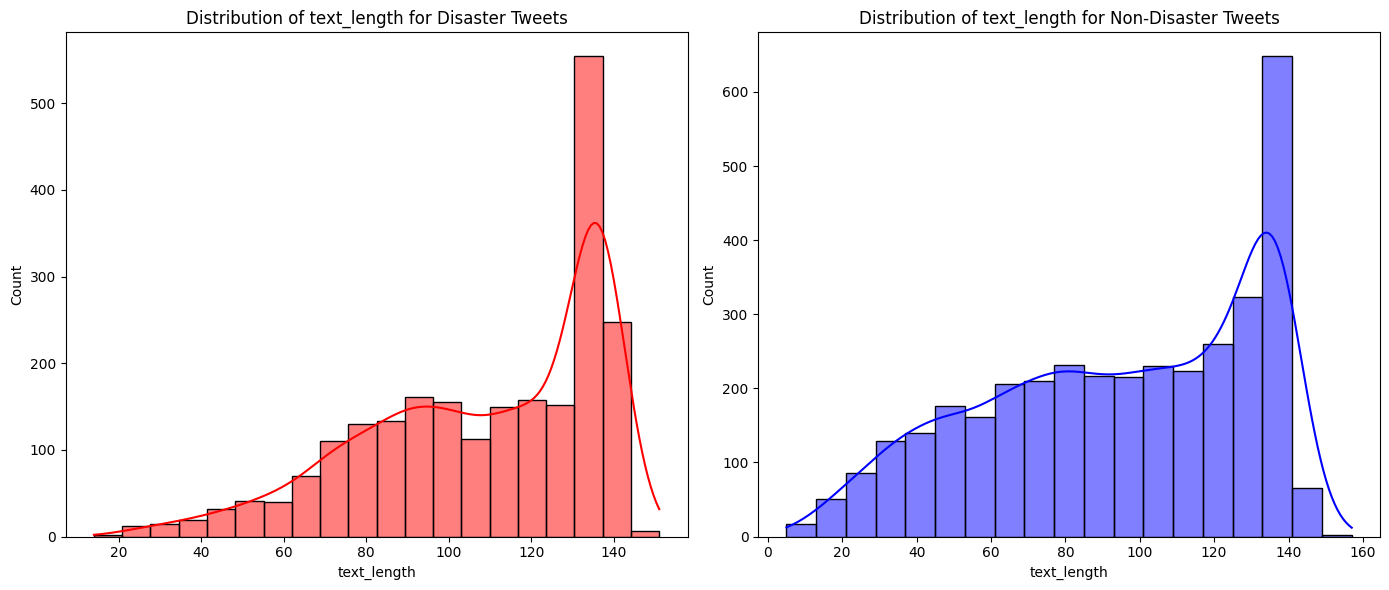

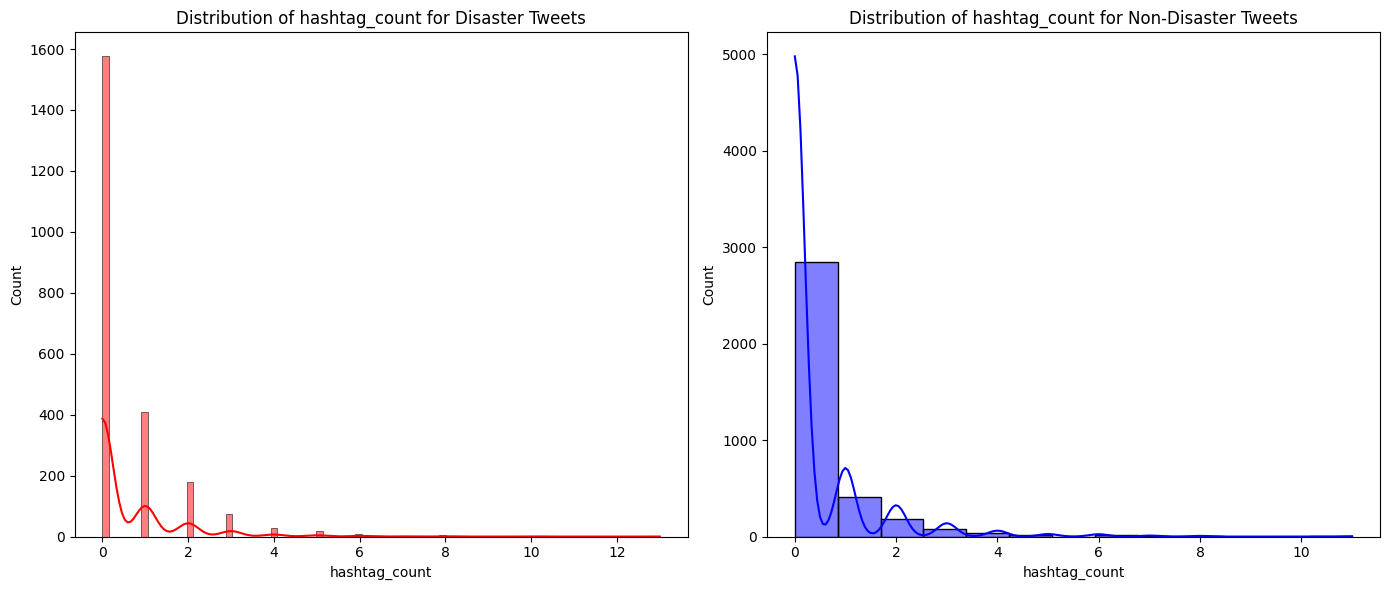

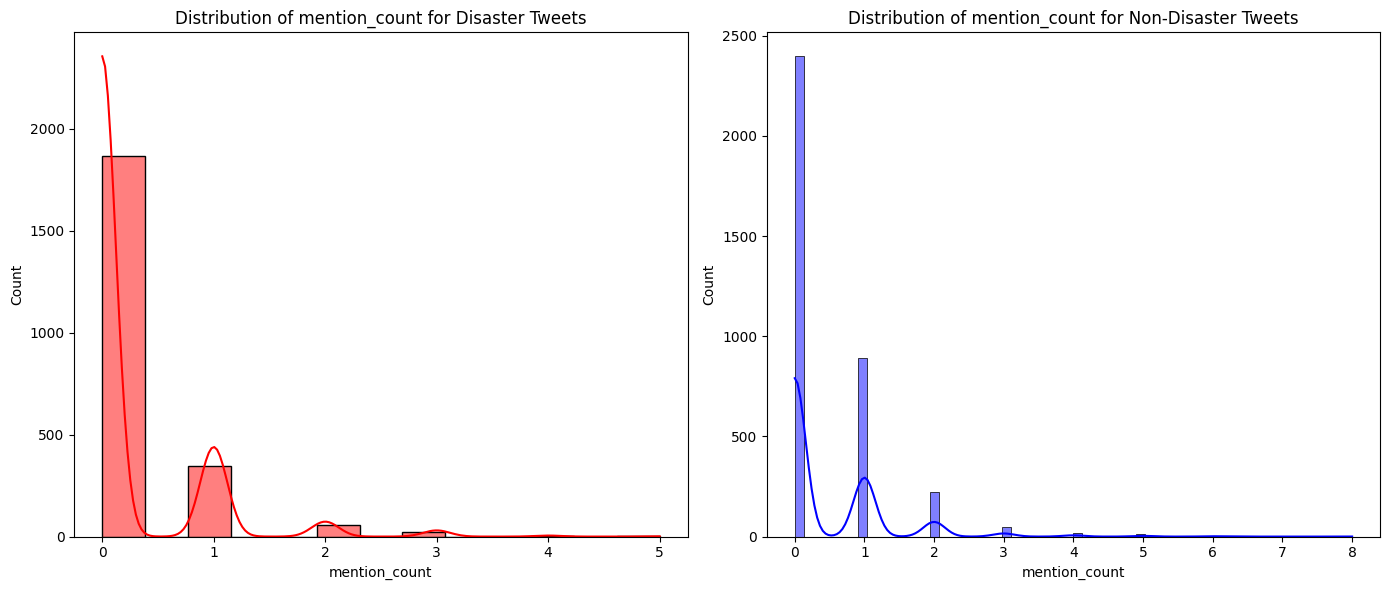

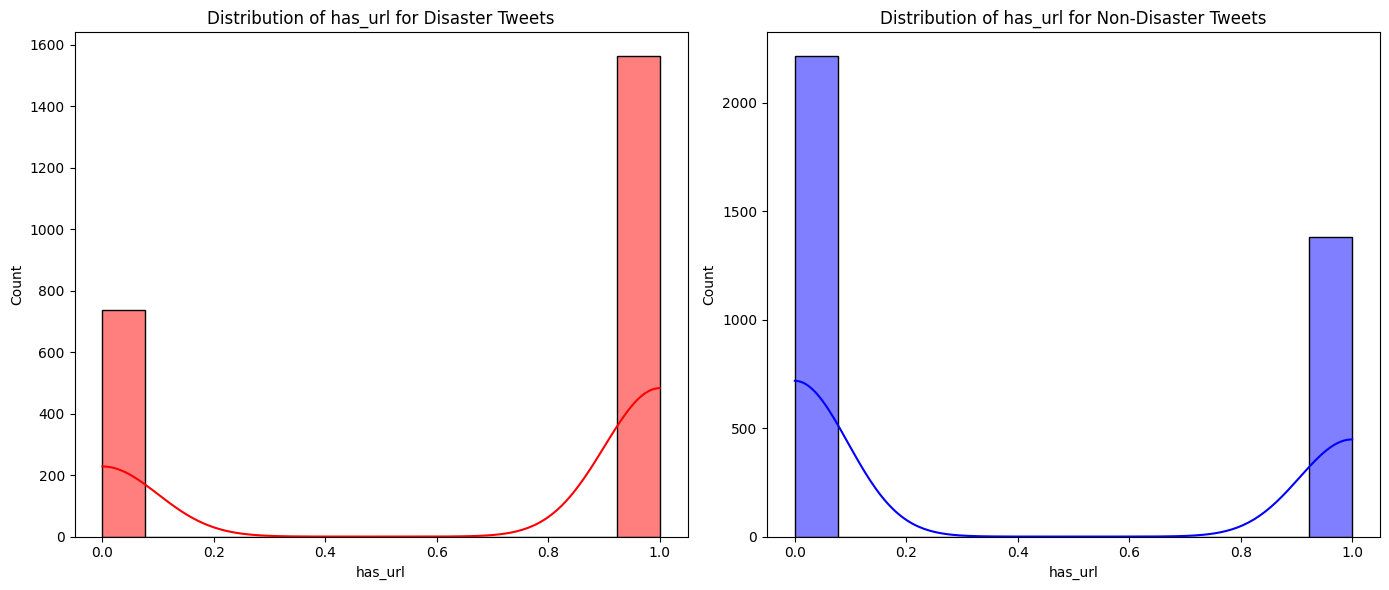

In [107]:
# Create a figure object and define the grid
def plot_distribution_difference(df, feature):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plotting using histplot instead of distplot
    sns.histplot(df[df['target'] == 1][feature], ax=ax[0], color='red', kde=True)  # kde=True will add a curve to the histogram
    sns.histplot(df[df['target'] == 0][feature], ax=ax[1], color='blue', kde=True)

    # Titles and labels
    ax[0].set_title('Distribution of {} for Disaster Tweets'.format(feature))
    ax[0].set_xlabel(feature)

    ax[1].set_title('Distribution of {} for Non-Disaster Tweets'.format(feature))
    ax[1].set_xlabel(feature)

    # Adjust layout
    plt.tight_layout()
    plt.show()

features = ['text_length', 'hashtag_count', 'mention_count', 'has_url']
for feature in features:
    plot_distribution_difference(df_train, feature)

### Sentiment analysis


In [108]:
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['compound']

df_train['sentiment'] = df_train['text'].apply(analyze_sentiment_vader)
df_test['sentiment'] = df_test['text'].apply(analyze_sentiment_vader)

df_train.sentiment.head()

0   -0.5574
1    0.4215
2   -0.0772
3   -0.7579
4    0.0000
Name: sentiment, dtype: float64

#### Checking if sentiment and target is correlated


In [109]:
df_train.columns

Index(['target', 'text', 'keyword', 'text_raw', 'id', 'text_length',
       'hashtag_count', 'mention_count', 'has_url', 'sentiment'],
      dtype='object')

In [110]:
disaster_group = df_train[df_train['target'] == 1]['sentiment']
not_disaster_group = df_train[df_train['target'] == 0]['sentiment']

t_statistic, p_value = stats.ttest_ind(disaster_group, not_disaster_group, equal_var=False)

p_value, t_statistic

(3.520081770393815e-102, -21.96539979122823)

### Ngrams

In [111]:
def create_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return n_grams


df_train['bigrams'] = df_train['text'].apply(lambda x: create_ngrams(x, 2))
df_train['trigrams'] = df_train['text'].apply(lambda x: create_ngrams(x, 3))

df_test['bigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 2))
df_test['trigrams'] = df_test['text'].apply(lambda x: create_ngrams(x, 3))

In [112]:
def create_ngrams_string(ngram_list):
    ngram_words = ['_'.join(ngram) for ngram in ngram_list]
    ngram_string = ' '.join(ngram_words)
    return ngram_string

def add_ngrams(df):
    df_temp = df.copy()

    df_temp['bigrams'] = df['bigrams'].apply(lambda x: create_ngrams_string(x))
    df_temp['trigrams'] = df['trigrams'].apply(lambda x: create_ngrams_string(x))

    df['text_with_ngrams'] = df['text'] + ' ' +  df_temp['bigrams'] + ' ' + df_temp['trigrams'] 
    return df

df_train = add_ngrams(df_train)
df_test = add_ngrams(df_test)

#### Explore ngrams

In [113]:

disaster_bigrams = df_train[df_train['target'] == 1]['bigrams']
non_disaster_bigrams = df_train[df_train['target'] == 0]['bigrams']

disaster_bigram_counts = Counter([gram for ngram_list in disaster_bigrams for gram in ngram_list])
non_disaster_bigram_counts = Counter([gram for ngram_list in non_disaster_bigrams for gram in ngram_list])

print("Most common n-grams in disaster-related tweets:")
print(disaster_bigram_counts.most_common(10))

print("\nMost common n-grams in non-disaster tweets:")
print(non_disaster_bigram_counts.most_common(10))

disaster_trigrams = df_train[df_train['target'] == 1]['trigrams']
non_disaster_trigrams = df_train[df_train['target'] == 0]['trigrams']

disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))

print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common n-grams in disaster-related tweets:
[(('suicide', 'bomber'), 47), (('do', 'not'), 34), (('i', 'am'), 33), (('severe', 'thunderstorm'), 32), (('suicide', 'bombing'), 28), (('wild', 'fire'), 28), (('thunderstorm', 'warning'), 26), (('heat', 'wave'), 25), (('northern', 'california'), 24), (('70', 'year'), 22)]

Most common n-grams in non-disaster tweets:
[(('i', 'am'), 230), (('do', 'not'), 126), (('can', 'not'), 77), (('you', 'are'), 74), (('going', 'to'), 41), (('youtube', 'video'), 30), (('i', 'have'), 30), (('that', 'is'), 30), (('liked', 'youtube'), 29), (('look', 'like'), 28)]
Most common trigrams in disaster-related tweets:
[(('severe', 'thunderstorm', 'warning'), 26), (('suicide', 'bomber', 'kill'), 17), (('suicide', 'bomber', 'detonated'), 17), (('pkk', 'suicide', 'bomber'), 15), (('bomber', 'detonated', 'bomb'), 15), (('northern', 'california', 'wildfire'), 15), (('officer', 'wounded', 'suspect'), 14), (('16yr', 'old', 'pkk'), 14), (('old', 'pkk', 'suicide'), 14), ((

In [114]:
disaster_trigrams = df_train[df_train['target'] == 1]['trigrams']
non_disaster_trigrams = df_train[df_train['target'] == 0]['trigrams']

disaster_trigram_counts = Counter([gram for ngram_list in disaster_trigrams for gram in ngram_list])
non_disaster_trigram_counts = Counter([gram for ngram_list in non_disaster_trigrams for gram in ngram_list])

print("Most common trigrams in disaster-related tweets:")
print(disaster_trigram_counts.most_common(10))

print("\nMost common trigrams in non-disaster tweets:")
print(non_disaster_trigram_counts.most_common(10))

Most common trigrams in disaster-related tweets:
[(('severe', 'thunderstorm', 'warning'), 26), (('suicide', 'bomber', 'kill'), 17), (('suicide', 'bomber', 'detonated'), 17), (('pkk', 'suicide', 'bomber'), 15), (('bomber', 'detonated', 'bomb'), 15), (('northern', 'california', 'wildfire'), 15), (('officer', 'wounded', 'suspect'), 14), (('16yr', 'old', 'pkk'), 14), (('old', 'pkk', 'suicide'), 14), (('detonated', 'bomb', 'turkey'), 14)]

Most common trigrams in non-disaster tweets:
[(('liked', 'youtube', 'video'), 29), (('i', 'am', 'going'), 20), (('pick', 'fan', 'army'), 16), (('likely', 'rise', 'top'), 14), (('rise', 'top', 'pay'), 14), (('top', 'pay', 'pile'), 14), (('do', 'not', 'know'), 13), (('ignition', 'knock', 'detonation'), 12), (('cross', 'body', 'bag'), 12), (('deluged', 'invoice', 'make'), 11)]


### Keyword feature

In [115]:
# One-Hot Encode the keywords
keyword_embedded_df = pd.get_dummies(df_train['keyword'])
keyword_embedded_test_df = pd.get_dummies(df_test['keyword'])

# Keywords that are present in the training set but not in the test set
missing_cols = set(keyword_embedded_df.columns) - set(keyword_embedded_test_df.columns)

# Add the missing columns to the test set with default value equal to 0
for c in missing_cols:
    keyword_embedded_test_df[c] = 0

# Set test column order to same order as train
keyword_embedded_test_df = keyword_embedded_test_df[keyword_embedded_df.columns]

In [116]:
# number of columns in the keyword embedded dataframe
keyword_embedded_df.shape

(5895, 222)

### Text feature - encoding using TF-IDF

In [117]:
vectorizer = TfidfVectorizer(max_features=1000)

feature_to_embed = 'text_with_ngrams'

# Fit and transform the training data
text_embedded = vectorizer.fit_transform(df_train[feature_to_embed])
text_embedded_df = pd.DataFrame(text_embedded.toarray(), columns=vectorizer.get_feature_names_out(), index=df_train.index)

# Transform the test data using the same vectorizer
text_embedded_test = vectorizer.transform(df_test[feature_to_embed])
text_embedded_test_df = pd.DataFrame(text_embedded_test.toarray(), columns=vectorizer.get_feature_names_out(), index=df_test.index)

In [118]:
df_train.head()

,target,text,keyword,text_raw,id,text_length,hashtag_count,mention_count,has_url,sentiment,bigrams,trigrams,text_with_ngrams
0,0,do not even remember slsp happening remember like wtf light turned everyone screamed encore,screamed,i dont even remember slsp happening i just remember being like wtf and then the lights turned off and everyone screamed for the encore,0,134,0,0,0,-0.5574,"[(do, not), (not, even), (even, remember), (remember, slsp), (slsp, happening), (happening, remember), (remember, like), (like, wtf), (wtf, light), (light, turned), (turned, everyone), (everyone, screamed), (screamed, encore)]","[(do, not, even), (not, even, remember), (even, remember, slsp), (remember, slsp, happening), (slsp, happening, remember), (happening, remember, like), (remember, like, wtf), (like, wtf, light), (wtf, light, turned), (light, turned, everyone), (turned, everyone, screamed), (everyone, screamed, encore)]",do not even remember slsp happening remember like wtf light turned everyone screamed encore do_not not_even even_remember remember_slsp slsp_happening happening_remember remember_like like_wtf wtf_light light_turned turned_everyone everyone_screamed screamed_encore do_not_even not_even_remember even_remember_slsp remember_slsp_happening slsp_happening_remember happening_remember_like remember_like_wtf like_wtf_light wtf_light_turned light_turned_everyone turned_everyone_screamed everyone_screamed_encore
1,0,hazelannmac ooh feel guilty wishing hatman bet mudslide delicious,mudslide,@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!,1,94,0,1,0,0.4215,"[(hazelannmac, ooh), (ooh, feel), (feel, guilty), (guilty, wishing), (wishing, hatman), (hatman, bet), (bet, mudslide), (mudslide, delicious)]","[(hazelannmac, ooh, feel), (ooh, feel, guilty), (feel, guilty, wishing), (guilty, wishing, hatman), (wishing, hatman, bet), (hatman, bet, mudslide), (bet, mudslide, delicious)]",hazelannmac ooh feel guilty wishing hatman bet mudslide delicious hazelannmac_ooh ooh_feel feel_guilty guilty_wishing wishing_hatman hatman_bet bet_mudslide mudslide_delicious hazelannmac_ooh_feel ooh_feel_guilty feel_guilty_wishing guilty_wishing_hatman wishing_hatman_bet hatman_bet_mudslide bet_mudslide_delicious
2,0,soultech collide club mix,collide,Soultech - Collide (Club Mix) http://t.co/8xIxBsPOT8,2,52,0,0,1,-0.0772,"[(soultech, collide), (collide, club), (club, mix)]","[(soultech, collide, club), (collide, club, mix)]",soultech collide club mix soultech_collide collide_club club_mix soultech_collide_club collide_club_mix
3,1,police officer wounded suspect dead exchanging shot,wounded,Police Officer Wounded Suspect Dead After Exchanging Shots - http://t.co/iPHaZV47g7,3,83,0,0,1,-0.7579,"[(police, officer), (officer, wounded), (wounded, suspect), (suspect, dead), (dead, exchanging), (exchanging, shot)]","[(police, officer, wounded), (officer, wounded, suspect), (wounded, suspect, dead), (suspect, dead, exchanging), (dead, exchanging, shot)]",police officer wounded suspect dead exchanging shot police_officer officer_wounded wounded_suspect suspect_dead dead_exchanging exchanging_shot police_officer_wounded officer_wounded_suspect wounded_suspect_dead suspect_dead_exchanging dead_exchanging_shot
4,0,cramer igers 3 word wrecked disney stock,wrecked,Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/4dGpBAiVL7,4,73,0,0,1,0.0000,"[(cramer, igers), (igers, 3), (3, word), (word, wrecked), (wrecked, disney), (disney, stock)]","[(cramer, igers, 3), (igers, 3, word), (3, word, wrecked), (word, wrecked, disney), (wrecked, disney, stock)]",cramer igers 3 word wrecked disney stock cramer_igers igers_3 3_word word_wrecked wrecked_disney disney_stock cramer_igers_3 igers_3_word 3_word_wrecked word_wrecked_disney wrecked_disney_stock


In [119]:
df_train.columns

Index(['target', 'text', 'keyword', 'text_raw', 'id', 'text_length',
       'hashtag_count', 'mention_count', 'has_url', 'sentiment', 'bigrams',
       'trigrams', 'text_with_ngrams'],
      dtype='object')

## 3. Selecting features

In [120]:
# storing this for later we can test different features without having to re-run cells above this one
df_checkpoint = df_train.copy()
df_test_checkpoint = df_test.copy()

In [121]:
# prepend all columns in keyword_embedded_df with 'keyword_'

keyword_embedded_df.columns = ['keyword_' + col for col in keyword_embedded_df.columns]
keyword_embedded_test_df.columns = ['keyword_' + col for col in keyword_embedded_test_df.columns]

In [122]:
features_to_keep = ['target', 'has_url', 'sentiment']

df_train = df_checkpoint[features_to_keep]
df_test = df_test_checkpoint[features_to_keep]

# extract y_train and y_test here to avoid column name collision with 'target' feature coming from text and keyword embeddings
y_train = df_train['target']
y_test = df_test['target']

# Concatenate the dataframes with td-idf features for the text feature
df_train = pd.concat([
    df_train,
    text_embedded_df,
    keyword_embedded_df
        ], axis=1)
df_test = pd.concat([df_test, text_embedded_test_df, 
                     keyword_embedded_test_df
                     
                     ], axis=1)

X_train = df_train.drop(['target'], axis=1)
X_test = df_test.drop(['target'], axis=1)

## 4. Modelling

In [123]:
def print_results(y_pred, y_train, y_pred_test, y_test):
    print("Train results")
    print("-----------------------------")
    print("Train accuracy: {}".format(accuracy_score(y_train, y_pred)))
    print(classification_report(y_train, y_pred))
    print(confusion_matrix(y_train, y_pred))

    print()
    print("Test results")
    print("-----------------------------")
    print("Test accuracy: {}".format(accuracy_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))
    print(confusion_matrix(y_test, y_pred_test))


### 4.1 Logistic regression

In [124]:
logreg = LogisticRegression(random_state=42, solver="liblinear")
logreg.fit(X_train, y_train)

y_pred = cross_val_predict(logreg, X_train, y_train, cv=5)  # 5-fold cross-validation
y_pred_test = logreg.predict(X_test)

print_results(y_pred, y_train, y_pred_test, y_test)

Train results
-----------------------------
Train accuracy: 0.8512298558100084
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      3595
           1       0.84      0.76      0.80      2300

    accuracy                           0.85      5895
   macro avg       0.85      0.84      0.84      5895
weighted avg       0.85      0.85      0.85      5895

[[3267  328]
 [ 549 1751]]

Test results
-----------------------------
Test accuracy: 0.8019301470588235
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1219
           1       0.81      0.71      0.76       957

    accuracy                           0.80      2176
   macro avg       0.80      0.79      0.80      2176
weighted avg       0.80      0.80      0.80      2176

[[1063  156]
 [ 275  682]]


In [125]:
# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 2, 4, 6, 8, 10, 100],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)

print_results(y_pred, y_train, y_pred_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best parameters: {'C': 4}
Train results
-----------------------------
Train accuracy: 0.9072094995759118
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      3595
           1       0.91      0.84      0.88      2300

    accuracy                           0.91      5895
   macro avg       0.91      0.90      0.90      5895
weighted avg       0.91      0.91      0.91      5895

[[3413  182]
 [ 365 1935]]

Test results
-----------------------------
Test accuracy: 0.8014705882352942
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1219
           1       0.81      0.71      0.76       957

    accuracy                           0.80      2176
   macro avg       0.80      0.79      0.80      2176
weighted avg       0.80      0.80      0.80      2176

[[1064  155]
 [ 277  680]]


In [126]:
def get_wrong_predictions(y_pred_test, y_test):
    # Calculate false positives and false negatives
    false_positives = np.where((y_pred_test == 1) & (y_test == 0))[0]
    false_negatives = np.where((y_pred_test == 0) & (y_test == 1))[0]

    return false_positives, false_negatives



In [127]:
false_positives, false_negatives = get_wrong_predictions(y_pred_test, y_test)

# num of false positives and false negatives
print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))

df_test_checkpoint.iloc[false_positives].to_csv('logreg_false_positives.csv', index=False)
df_test_checkpoint.iloc[false_negatives].to_csv('logreg_false_negatives.csv', index=False)

Number of False Positives: 155
Number of False Negatives: 277


In [128]:
# Compare predicted labels with actual labels in X_train
correct = [(True, x) for x in y_pred_test]

false_positives = y_pred_test 


y_pred_test

# filter out 
df_test_checkpoint

for i in range(0, len(y_pred_test)):
    if y_pred_test[i] != y_test[i]:
        correct[i] = (False, y_pred_test[i], y_test[i])

for i,x in enumerate(correct):
    if not x[0]:
        print(df_test_checkpoint.iloc[i]['text_raw'], correct[i][1])
        print("\n\n")


The sunset looked like an erupting volcano .... My initial thought was the Pixar short Lava http://t.co/g4sChqFEsT 0



#7294 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/SL7PHqSGKV

$200.00
_ http://t.co/T4Qh2OM8Op 0



Ever since Kelly's burned I keep having dreams about being inside burning buildings ?? 1



Violent Forces Radio: Now Playing Acid Storm - Scourgue Of The Gods
TuneIn Player @ http://t.co/XsSgEdSbH4 0



Billionaires have a plan to free half a billion dollars trapped in Venezuela for two years @BlakeSchmidt reports.

http://t.co/gbqTc7Sp9C 1



Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/0f8XA4Ih1U 0



Is he about to crash?
Did the Queen die?
Did something explode? 
Who knows. http://t.co/LThMwtl5fP 0



The sign-up is open for the FALLING FOR DANGER release day blast and review tour. Sign-up here:... http://t.co/hbdo22nqPZ 0



@RachelRofe tired

## xgboost

In [129]:
# Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.9}

import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9
}

params_edited = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.9}

num_round = 250
model = xgb.train(params, dtrain, num_round)


y_pred = model.predict(dtest)
y_pred_train = model.predict(dtrain)
y_pred_binary = np.array([1 if pred > 0.5 else 0 for pred in y_pred])
y_pred_train_binary = [1 if pred > 0.5 else 0 for pred in y_pred_train]


accuracy = accuracy_score(y_test, y_pred_binary)

print_results(y_pred=y_pred_train_binary, y_train=y_train, y_pred_test=y_pred_binary, y_test=y_test)



Train results
-----------------------------
Train accuracy: 0.9935538592027142
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3595
           1       1.00      0.99      0.99      2300

    accuracy                           0.99      5895
   macro avg       0.99      0.99      0.99      5895
weighted avg       0.99      0.99      0.99      5895

[[3584   11]
 [  27 2273]]

Test results
-----------------------------
Test accuracy: 0.7913602941176471
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1219
           1       0.78      0.73      0.76       957

    accuracy                           0.79      2176
   macro avg       0.79      0.78      0.79      2176
weighted avg       0.79      0.79      0.79      2176

[[1022  197]
 [ 257  700]]


In [130]:
# false_positives, false_negatives = get_wrong_predictions(y_pred_binary, y_test)

false_positives = np.where((y_pred_binary == 1) & (y_test == 0))[0]
false_negatives = np.where((y_pred_binary == 0) & (y_test == 1))[0]

# num of false positives and false negatives
print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))

df_test_checkpoint.iloc[false_positives].to_csv('xgb_false_positives.csv', index=False)
df_test_checkpoint.iloc[false_negatives].to_csv('xgb_false_negatives.csv', index=False)

Number of False Positives: 197
Number of False Negatives: 257


## Adaboost

In [131]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost Classifier
adaboost = AdaBoostClassifier(random_state=0)

param_grid = {
    'n_estimators': [200, 250, 300],
    'learning_rate': [0.01, 0.1, 1, 2, 3],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Generate cross-validated predictions for the training set
y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)

# Predict on the test set
y_pred_test = best_model.predict(X_test)

print_results(y_pred_train, y_train, y_pred_test, y_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=200; total time=   6.3s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=200; total time=   6.3s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=200; total time=   6.3s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=200; total time=   6.5s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=200; total time=   6.7s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=250; total time=   7.8s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=250; total time=   7.9s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=250; total time=   8.1s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=250; total time=   8.2s
[CV] END algorithm=SAMME, learning_rate=0.01, n_estimators=250; total time=   8.4s
[CV] END algorithm=SAMME, learning_rate=0.1, n_estimators=200; total time=   6.9s
[CV] END algorithm=SAMME, 

In [132]:
false_positives = np.where((y_pred_test == 1) & (y_test == 0))[0]
false_negatives = np.where((y_pred_test == 0) & (y_test == 1))[0]

# num of false positives and false negatives
print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))

df_test_checkpoint.iloc[false_positives].to_csv('adaboost_false_positives.csv', index=False)
df_test_checkpoint.iloc[false_negatives].to_csv('adaboost_false_negatives.csv', index=False)

Number of False Positives: 186
Number of False Negatives: 291


In [137]:
# read files 
# "logreg_false_negatives.csv", "logreg_false_positives.csv"
# "xgb_false_negatives.csv", "xgb_false_positives.csv"
# "adaboost_false_negatives.csv", "adaboost_false_positives.csv"

df1 = pd.read_csv("logreg_false_negatives.csv")[["text_raw", "id"]]
df2 = pd.read_csv("logreg_false_positives.csv")[["text_raw", "id"]]
df3 = pd.read_csv("xgb_false_negatives.csv")[["text_raw", "id"]]
df4 = pd.read_csv("xgb_false_positives.csv")[["text_raw", "id"]]
df5 = pd.read_csv("adaboost_false_negatives.csv")[["text_raw", "id"]]
df6 = pd.read_csv("adaboost_false_positives.csv")[["text_raw", "id"]]

# find rows with same values in "text" columns in df1, df3, df5

common_false_negatives = pd.merge(df1, df3, on="id", how="inner")
common_false_negatives = pd.merge(common_false_negatives, df5, on="id", how="inner")

common_false_positives = pd.merge(df2, df4, on="id", how="inner")
common_false_positives = pd.merge(common_false_positives, df6, on="id", how="inner")

common_false_negatives_ids = common_false_negatives["id"]
common_false_positives_ids = common_false_positives["id"]

common_false_negatives = df1[df1["id"].isin(common_false_negatives_ids)]
common_false_positives = df2[df2["id"].isin(common_false_positives_ids)]

common_false_negatives.to_csv("common_false_negatives.csv", index=False)
common_false_positives.to_csv("common_false_positives.csv", index=False)

print(len(common_false_negatives))
print(len(common_false_positives))


# 

182
87


In [151]:
df1 = pd.read_csv("logreg_false_negatives.csv")[["text_raw", "id"]]
df2 = pd.read_csv("logreg_false_positives.csv")[["text_raw", "id"]]
df3 = pd.read_csv("xgb_false_negatives.csv")[["text_raw", "id"]]
df4 = pd.read_csv("xgb_false_positives.csv")[["text_raw", "id"]]
df5 = pd.read_csv("adaboost_false_negatives.csv")[["text_raw", "id"]]
df6 = pd.read_csv("adaboost_false_positives.csv")[["text_raw", "id"]]


# find difference between df1, df3, df5 and mark each row with the name of the df

# Add a column to each DataFrame to mark its origin
df1['source'] = 'logreg'
df2['source'] = 'logreg'
df3['source'] = 'xgb'
df4['source'] = 'xgb'
df5['source'] = 'adaboost'
df6['source'] = 'adaboost'

# Concatenate the DataFrames
combined_df = pd.concat([df1, df3, df5])

# Drop duplicates based on 'text_raw' and 'id' columns to find unique rows
unique_rows = combined_df.drop_duplicates(subset=['id'], keep=False)

unique_rows.to_csv("unique_false_negatives.csv", index=False)

# Concatenate the DataFrames
combined_df = pd.concat([df2, df4, df6])

# Drop duplicates based on 'text_raw' and 'id' columns to find unique rows
unique_rows = combined_df.drop_duplicates(subset=['id'], keep=False)

unique_rows.to_csv("unique_false_positives.csv", index=False)



,text_raw,id,source
1,#7294 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/SL7PHqSGKV\n\n$200.00\n_ http://t.co/T4Qh2OM8Op,1,logreg
4,Is he about to crash?\nDid the Queen die?\nDid something explode? \nWho knows. http://t.co/LThMwtl5fP,27,logreg
31,@ShaunKing Check this out: Tribute to survivors of sexual assault by law enforcement officers on facebook.,226,logreg
54,Man Hears a Loud 'Bang' Finds a Newborn Baby in a Dumpster http://t.co/W815ol0mBV via @ijreview,407,logreg
69,Infections driving up neonatal deaths Health Minister #Guyana http://t.co/ImugNXrEBN,541,logreg


In [140]:
# rows in df3 that are not in common_false_negatives based on id

df7 = df1[~df1["id"].isin(common_false_negatives_ids)]
df8 = df3[~df3["id"].isin(common_false_negatives_ids)]
df9 = df5[~df5["id"].isin(common_false_negatives_ids)]

print(len(df7), len(df8), len(df9))


95 75 109
